## Стихи Пушкина

In [8]:
!pip install datasets


[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [135]:
import torch

from torch.nn import functional as F

In [136]:
from datasets import load_dataset

raw_datasets = load_dataset("abobster/pushkin_new")

with open('input.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(raw_datasets['train']['text']))

/Users/timoniche/PycharmProjects/dl/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [137]:
# !cat input.txt

In [138]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print('device', device)

device mps


In [151]:
batch_size = 64  # independent sequences processed in parallel
block_size = 256  # maximum context length for predictions

learning_rate = 3e-4

n_embd = 384
dropout = 0.2

In [141]:
torch.manual_seed(1337)

with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
print('vocab_size', vocab_size)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

vocab_size 131


## Модель

In [142]:
import torch.nn as nn


class ModelRNN(nn.Module):
    def __init__(
            self,
            vocab_size,
            hidden_size,
            dropout,
            num_layers=1,
    ):
        super(ModelRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        output, hidden = self.lstm(x, hidden)
        output = self.dropout(output)
        output = self.fc(output)

        return output, hidden


In [143]:
model = ModelRNN(
    vocab_size=vocab_size,
    hidden_size=n_embd,
    dropout=dropout,
)
m = model.to(device)

print(sum(p.numel() for p in m.parameters()) / 1e6, 'M parameters')

1.283459 M parameters


In [152]:
from time import time

eval_iters = 200

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i + block_size] for i in ix])
    y = torch.stack([data[i + 1:i + block_size + 1] for i in ix])
    x, y = x.to(device), y.to(device)

    return x, y


@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, _ = model(X)
            loss = F.cross_entropy(logits.view(-1, vocab_size), Y.view(-1))
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [153]:
from utils import cur_dir

save_path = cur_dir() + '/rnnmodel.pth'

In [178]:
from tqdm import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

max_iters = 5000
eval_interval = 500
store_losses = True

t0 = time()
train_losses = []
val_losses = []
for i in tqdm(range(max_iters)):
    if store_losses and (i % eval_interval == 0 or i == max_iters - 1):
        cur_loss = estimate_loss()
        
        train_loss = cur_loss['train']
        val_loss = cur_loss['val']
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"step {i}: train loss {train_loss:.4f}, val loss {val_loss:.4f}, elapsed: {time() - t0:.1f}s")

    xb, yb = get_batch('train')
    logits, _ = model(xb)
    loss = F.cross_entropy(logits.view(-1, vocab_size), yb.view(-1))

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

torch.save(model.state_dict(), save_path)

  0%|          | 1/5000 [00:07<10:48:10,  7.78s/it]

step 0: train loss 2.5908, val loss 2.6202, elapsed: 7.7s


 10%|█         | 505/5000 [00:37<41:27,  1.81it/s] 

step 500: train loss 2.5900, val loss 2.6193, elapsed: 37.4s


 20%|██        | 1003/5000 [01:06<49:29,  1.35it/s]

step 1000: train loss 2.5905, val loss 2.6204, elapsed: 66.9s


 30%|███       | 1504/5000 [01:37<36:57,  1.58it/s]

step 1500: train loss 2.5906, val loss 2.6181, elapsed: 97.6s


 40%|████      | 2002/5000 [02:08<44:20,  1.13it/s]

step 2000: train loss 2.5912, val loss 2.6189, elapsed: 128.6s


 50%|█████     | 2503/5000 [02:38<33:17,  1.25it/s]

step 2500: train loss 2.5904, val loss 2.6195, elapsed: 158.7s


 60%|██████    | 3004/5000 [03:08<17:41,  1.88it/s]

step 3000: train loss 2.5917, val loss 2.6204, elapsed: 188.1s


 70%|███████   | 3505/5000 [03:37<13:36,  1.83it/s]

step 3500: train loss 2.5889, val loss 2.6193, elapsed: 217.6s


 80%|████████  | 4003/5000 [04:07<12:34,  1.32it/s]

step 4000: train loss 2.5896, val loss 2.6206, elapsed: 247.1s


 90%|█████████ | 4504/5000 [04:37<04:39,  1.78it/s]

step 4500: train loss 2.5907, val loss 2.6196, elapsed: 276.9s


100%|██████████| 5000/5000 [05:07<00:00, 16.27it/s]

step 4999: train loss 2.5902, val loss 2.6191, elapsed: 307.3s


## Посмотрим на train и val cross-entropy losses

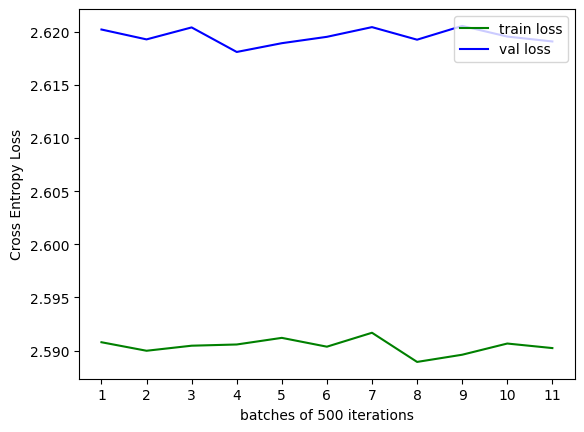

In [181]:
import matplotlib.pyplot as plt

plt.plot(train_losses, 'g', label='train loss')
plt.plot(val_losses, 'b', label='val loss')

plt.xlabel(f'batches of {eval_interval} iterations')
plt.ylabel('Cross Entropy Loss')

plt.xticks(range(len(train_losses)), range(1, len(train_losses) + 1))

plt.legend(loc='upper right')

plt.show()

In [182]:
# model.load_state_dict(torch.load(save_path))

In [183]:
def generate(model, seed_text, tokens_cnt):
    model.eval()

    generated = seed_text.clone()
    for _ in tqdm(range(tokens_cnt)):
        logits, _ = model(generated)
        last_token_logits = logits[:, -1, :]
        probs = F.softmax(last_token_logits, dim=-1)
        sampled_token = torch.multinomial(probs, 1)
        generated = torch.cat((generated, sampled_token), dim=1)

    return generated

In [184]:
seed_text = 'О вы, которые любовью не горели'
print(f'Seed text: {seed_text}')

context = torch.tensor(encode(seed_text), dtype=torch.long, device=device).unsqueeze(0)

tokens_to_generate = 200
generated = generate(model, context, tokens_to_generate)

generated_text = decode(generated[0].tolist())

print(generated_text)

Seed text: О вы, которые любовью не горели


100%|██████████| 200/200 [00:00<00:00, 322.21it/s]

О вы, которые любовью не горелича коюбей
Вскрашуде ух мовогой мфь, гленой.
И повемой чугла; Тета нобобушу ст,
Свиза пр,
Нак. т позм шкрави — ем,
Отедонотал;
Им. Вст, бирее и?.
Отицои о-такой эт прдогеци,
Сря,
Посьш,
И орфодо стене 


In [31]:
!pip install --upgrade pip
!pip install --upgrade setuptools
!pip install lxml

!pip install sacrebleu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.5/819.5 kB 3.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: setuptools
    Found existing installation: setuptools 65.5.1
    Uninstalling setuptools-65.5.1:
      Successfully uninstalled setuptools-65.5.1
  Using cached lxml-5.0.0.zip (4.1 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for lxml: filename=lxml-5.0.0-cp39-cp39-macosx_10_9_universal2.whl size=3210317 sha256=9065d967a4a52801700ab9981e41fe0c731b4d89ee2614af093151253560344c
  Stored in directory: /Users/timoniche/Library/Caches/pip/wheels/b3/f3/c8/7d32062bb4d205cfc564ff338613b965f852cfb428224a1e96
Successfully built lxml


In [185]:
references = [
    '''
    Лагерь при Евфрате
    Не пленяйся бранной славой,
    О красавец молодой!
    Не бросайся в бой кровавый
    С карабахскою толпой!
    Знаю, смерть тебя не встретит:
    Азраил, среди мечей,
    Красоту твою заметит —
    И пощада будет ей!
    Но боюсь: среди сражений
    Ты утратишь навсегда
    Скромность робкую движений,
    Прелесть неги и стыда! 
    ''',
    '''
    О вы, которые любовью не горели,
    Взгляните на нее — узнаете любовь.
    О вы, которые уж сердцем охладели,
    Взгляните на нее: полюбите вы вновь. 
    ''',
    '''
    Все кончено: меж нами связи нет.
    В последний раз обняв твои колени,
    Произносил я горестные пени.
    Все кончено — я слышу твой ответ.
    Обманывать себя не стану вновь,
    Тебя тоской преследовать не буду,
    Прошедшее, быть может, позабуду —
    Не для меня сотворена любовь.
    Ты молода: душа твоя прекрасна,
    И многими любима будешь ты. 
    ''',
]

## Попросим нагенерить из сидов, равных первому предложению

In [186]:
seeds = [ref.splitlines()[1] for ref in references]

ref_lens = [len(ref) for ref in references]
seed_lens = [len(seed) for seed in seeds]
cnt_to_generate = [r_len - s_len for r_len, s_len in zip(ref_lens, seed_lens)]

print('Seed texts: ')
print(seeds)

Seed texts: 
['    Лагерь при Евфрате', '    О вы, которые любовью не горели,', '    Все кончено: меж нами связи нет.']


In [187]:
generated_texts = []
for i in range(len(seeds)):
    context = torch.tensor(encode(seeds[i]), dtype=torch.long, device=device).unsqueeze(0)
    tokens_to_generate = cnt_to_generate[i]
    generated = generate(model, context, tokens_to_generate)
    generated_text = decode(generated[0].tolist())
    generated_texts.append(generated_text)

    print(generated_text)

100%|██████████| 343/343 [00:00<00:00, 343.83it/s]


    Лагерь при Евфратестай и ститылаб т горилин. олыедодисо: чтой,
Зи о м,
Раст,
Пой слставя!
Плеча гой ны орх момосемнасешь,
Грой,
Нот;
Коминодрдоног Рою взк бобв пртаноли зл,
На?
Всвиялиеснущазко т.
Ужепось слатюбым
Изи ся зав нитв жетрщене,
И ще,
Ней х чит,, истл?
В ва нь,
На,
Вистами дома н,
Те сказен, прерорк мест вихир мост:
Прив в бмел ороильбя.
И орисевец


100%|██████████| 126/126 [00:00<00:00, 449.03it/s]


    О вы, которые любовью не горели, ристсежевотаднаковсу икасенит,
Обиры х,
И нный к Крвь неньязавинния, бли онице бы. сь
Гадца довицизм трера, вздинью,
Иле о сн


100%|██████████| 331/331 [00:00<00:00, 466.46it/s]

    Все кончено: меж нами связи нет.
Нешь, гдора
Таставлою
В N.
В сесто
И бкордвсьстирищенолан слни манищем ви
Тосвать ст.
Всн угою погдвяна,
Вой, всад
Катеря тиякр икане чав делю клуй ви,
Куясстимины, нечиныхотолих белом,
Оныстижерде чихв
— бвуждны ви, — и нтс боятадцеравце, тоженыезадобя я:
Зах пру зум Гдей стны срядвою
Ноденая?
Увопраже
Срицам ломуки осира
Встра


In [190]:
from sacrebleu import sentence_chrf

scores = [sentence_chrf(gen, references).score for gen in generated_texts]

print('chrF scores: ')
print(scores)

chrF scores: 
[24.603619017659557, 33.3915931378405, 28.290093488073758]


## Сравним chrF если бы генерили без совпадающего сида

In [191]:
seed_text = ' '

context = torch.tensor(encode(seed_text), dtype=torch.long, device=device).unsqueeze(0)

tokens_to_generate = 200
generated = generate(model, context, tokens_to_generate)

generated_text = decode(generated[0].tolist())

print('Generated text: ')
print(generated_text)

scores = [sentence_chrf(gen, references).score for gen in generated_texts]

print('chrF scores: ')
print(scores)



100%|██████████| 200/200 [00:00<00:00, 386.49it/s]

Generated text: 
 обы з-твстьготралаго см, уныелору мн со «Душедних ги твазр.
И Лизот? Онене и лгоейц! побило, т нь та вепалогонсвламетамоном,
И ризеедонодадрекре стонохане к сей пржера факреримален! с норототаль лча и
chrF scores: 
[24.603619017659557, 33.3915931378405, 28.290093488073758]


## Попробуем модель с GRU